In [1]:
# import all packages we will need

import numpy as np
import pandas as pd
import scipy.sparse as sp 
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.neural_network import MLPRegressor
from sklearn.linear_model import LinearRegression, RidgeCV
from sklearn.metrics import r2_score
from sklearn.model_selection import ParameterGrid
import matplotlib.pyplot as plt

# Data Acquisition

In [2]:
# import the development set

dev_df = pd.read_csv('dev.tsv', delimiter='\t', header=0)
dev_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 120744 entries, 0 to 120743
Data columns (total 9 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   country      120739 non-null  object 
 1   description  120744 non-null  object 
 2   designation  84226 non-null   object 
 3   province     120739 non-null  object 
 4   region_1     100736 non-null  object 
 5   region_2     48736 non-null   object 
 6   variety      120744 non-null  object 
 7   winery       120744 non-null  object 
 8   quality      120744 non-null  float64
dtypes: float64(1), object(8)
memory usage: 8.3+ MB


# Data Exploration

In [3]:
# plot the distribution of 'quality' field over data

def plot_score_distr(df):
    scores = np.array(range(101))
    occs = np.array([(df['quality']==score).sum() for score in scores])
    
    fig,ax= plt.subplots(figsize=(20,6))
    ax.bar(scores, occs, width=0.75)
    plt.xlabel('Quality score', fontsize=40)
    plt.ylabel('# occurrencies', fontsize=40)
    plt.xticks(fontsize=25)
    plt.yticks(fontsize=25)
    ax.grid(True)
    return fig

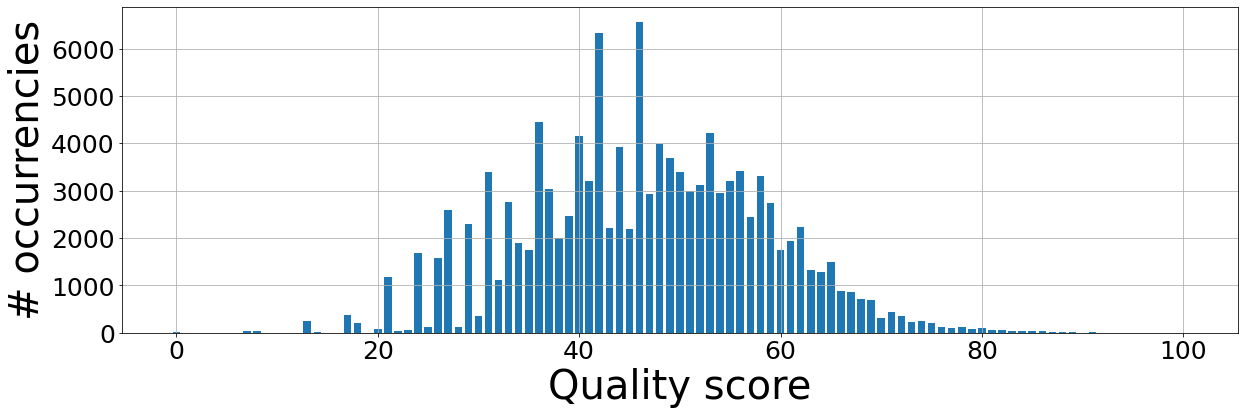

In [4]:
figure = plot_score_distr(dev_df)

In [5]:
figure.savefig('barchartfull.eps', format='eps', bbox_inches='tight')

In [6]:
# duplicate detection and removal

print(f'In dev_df there are {dev_df.duplicated().sum()} duplicated rows.\n')
red_df = dev_df.drop_duplicates()
red_df.info()

In dev_df there are 35716 duplicated rows.

<class 'pandas.core.frame.DataFrame'>
Int64Index: 85028 entries, 0 to 120738
Data columns (total 9 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   country      85025 non-null  object 
 1   description  85028 non-null  object 
 2   designation  59084 non-null  object 
 3   province     85025 non-null  object 
 4   region_1     71139 non-null  object 
 5   region_2     34294 non-null  object 
 6   variety      85028 non-null  object 
 7   winery       85028 non-null  object 
 8   quality      85028 non-null  float64
dtypes: float64(1), object(8)
memory usage: 6.5+ MB


In [7]:
# unique values exploration

features = red_df.drop(columns='quality').columns

for field in features:
    print(f"The number of unique values for '{field}' is: {len(list(filter(None, red_df[field].fillna('').unique())))}.")

The number of unique values for 'country' is: 48.
The number of unique values for 'description' is: 85005.
The number of unique values for 'designation' is: 27800.
The number of unique values for 'province' is: 444.
The number of unique values for 'region_1' is: 1206.
The number of unique values for 'region_2' is: 18.
The number of unique values for 'variety' is: 603.
The number of unique values for 'winery' is: 14105.


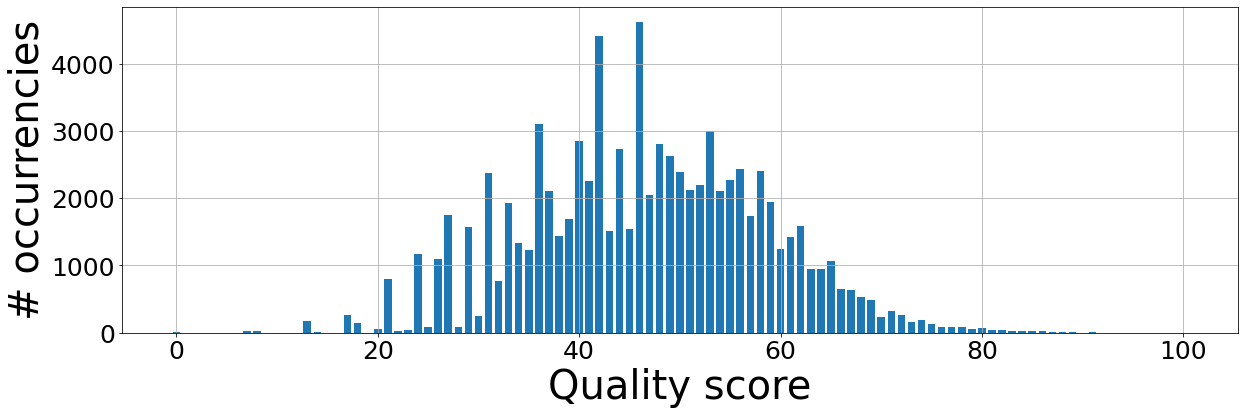

In [8]:
# distribution of 'quality' field over reduced data

fig_red = plot_score_distr(red_df)

In [9]:
# exploration of rows with duplicated 'description'

red_df[red_df.duplicated(subset='description', keep=False)].sort_values(by='description')
# sometimes two identical descriptions refer to 2 really similar wines, and led to the same scores; other times they refer to 2 completely apart wines: 
# so it's not a good idea to consider only this field for the algorithm development.

,country,description,designation,province,region_1,region_2,variety,winery,quality
65746,France,"92-94 Barrel sample. A big, concentrated, powe...",Barrel sample,Bordeaux,Saint-Julien,NaN,Bordeaux-style Red Blend,Château Talbot,62.0
8703,France,"92-94 Barrel sample. A big, concentrated, powe...",Barrel sample,Bordeaux,Saint-Julien,NaN,Bordeaux-style Red Blend,Château Langoa Barton,62.0
37642,France,"92-94 Barrel sample. A rounded wine, its tanni...",Barrel sample,Bordeaux,Pauillac,NaN,Bordeaux-style Red Blend,Château Fonbadet,62.0
56539,France,"92-94 Barrel sample. A rounded wine, its tanni...",Barrel sample,Bordeaux,Pauillac,NaN,Bordeaux-style Red Blend,Château Duhart-Milon,62.0
35156,France,92–94. Barrel sample. With so much spicy fruit...,Barrel Sample,Bordeaux,Pauillac,NaN,Bordeaux-style Red Blend,Château Grand-Puy-Lacoste,62.0
105383,France,92–94. Barrel sample. With so much spicy fruit...,Barrel Sample,Bordeaux,Saint-Julien,NaN,Bordeaux-style Red Blend,Château Gruaud Larose,62.0
57435,Portugal,"A lean, cool, initially austere wine, well bal...",Reserva,Douro,NaN,NaN,Portuguese Red,Poças,48.0
45921,Portugal,"A lean, cool, initially austere wine, well bal...",NaN,Beiras,NaN,NaN,Portuguese Red,Quinta de Foz de Arouce,53.0
26883,Argentina,A little bit funky and unsettled when you pop ...,NaN,Mendoza Province,Mendoza,NaN,Malbec,Mariana,27.0
11236,France,A little bit funky and unsettled when you pop ...,Domaine Vincent Sauvestre Clos de la Platière,Burgundy,Pommard,NaN,Pinot Noir,Maison Jean-Baptiste Béjot,42.0


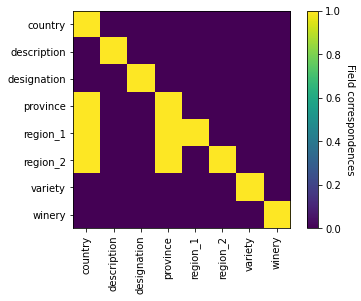

In [10]:
# i want to check if there is some kind of 'field comprehension' (if there's a field that embodies all the information of another)

def check_correspondence(df, field1, field2):
    for _, subset in df.groupby(field1):
        if (subset[field2].unique().size + ~(subset[field2].isna().any())) != 2:
            return False
    return True

grid= {'df':[red_df], 'field1': features, 'field2': features}
correspondences = []

for config in ParameterGrid(grid):
    correspondences.append(check_correspondence(**config))
    
correspondences = np.reshape(correspondences, (len(features),len(features)))

fig, ax = plt.subplots()
im = ax.imshow(correspondences)
ax.set_xticks(np.arange(len(features)))
ax.set_yticks(np.arange(len(features)))
ax.set_xticklabels(features)
ax.set_yticklabels(features)
plt.setp(ax.get_xticklabels(), rotation=90, ha="right", va="center",
         rotation_mode="anchor")
cbar = ax.figure.colorbar(im, ax=ax)
_ = cbar.ax.set_ylabel('Field correspondences', rotation=-90, va="bottom")

# the analysis showed how all the info contained in 'country' is fully enclosed in 'province', 
# so we can safely state there is no reason to take 'country' into account unless we consider 'province'.
# we can't made such assumptions for 'region_1' and 'region_2' since there are much more null values in them.

In [11]:
fig.savefig('heatcorr.eps', format='eps', bbox_inches='tight')

# Data Preprocessing

In [12]:
# 1st try: model the 2 simplest fields other than country

red_df_1h = sp.csr_matrix(pd.get_dummies(red_df.drop(columns=[
                                    'country', 'quality', 'description', 'designation', 'region_1', 'region_2', 'winery']), columns=['province', 'variety'], sparse=True))
y = red_df['quality']
red_df_1h

<85028x1047 sparse matrix of type '<class 'numpy.uint8'>'
	with 170053 stored elements in Compressed Sparse Row format>

In [13]:
X_train, X_test, y_train, y_test = train_test_split(red_df_1h, y, random_state=42, train_size=0.8)
reg = RidgeCV(cv=5, scoring='r2')
reg.fit(X_train, y_train)
r2_score(y_test, reg.predict(X_test))

0.31082569830754725

In [14]:
# 2nd try: add the 'description', modeled with Binary tf; we use an external library to do the 'stemming' process
from textblob import TextBlob
import nltk

nltk.download('stopwords')
nltk.download('punkt')

sw = nltk.corpus.stopwords.words("english")
separator = ' '
sw = separator.join(sw)

def textblob_tokenizer(str_input):
    blob = TextBlob(str_input.lower())
    tokens = blob.words
    words = [token.stem() for token in tokens]
    return words

vect_desc = TfidfVectorizer(tokenizer=textblob_tokenizer, stop_words=textblob_tokenizer(sw), binary=True, use_idf=False, norm=False, min_df=4) # since we're stemming the words in documents, we also need to stem stopwords
tf_desc = vect_desc.fit_transform(red_df['description'])

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\lucac\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\lucac\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
c:\users\lucac\appdata\local\programs\python\python39\lib\site-packages\sklearn\feature_extraction\text.py:388: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['becau'] not in stop_words.
  warnings.warn('Your stop_words may be inconsistent with '


In [15]:
X = sp.hstack((tf_desc, red_df_1h), format='csr')
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, train_size=0.8)
reg = RidgeCV(cv=5, scoring='r2')
reg.fit(X_train, y_train)
r2_score(y_test, reg.predict(X_test))

# good improvement; let's move further

0.5407900491051748

In [16]:
# 3rd try: add the 'designation', modeled with Binary tf; this time stemming isn't required

vect_desig = TfidfVectorizer(stop_words='english', binary=True, use_idf=False, norm=False, min_df=2) 
tf_desig = vect_desig.fit_transform(red_df['designation'].fillna(''))
X = sp.hstack((tf_desig, tf_desc, red_df_1h))
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, train_size=0.8)
reg = RidgeCV(cv=5, scoring='r2')
reg.fit(X_train, y_train)
r2_score(y_test, reg.predict(X_test))

# quality keeps improving, the model is still learning: we can go on adding fields

0.5860400604497652

In [17]:
# 4th try: add the 'region_1', modeled with 1-hot encode

red_df_1h = sp.csr_matrix(pd.get_dummies(red_df.drop(columns=[
                                    'country', 'quality', 'description', 'designation', 'region_2', 'winery']), columns=['province', 'variety', 'region_1'], sparse=True))
X = sp.hstack((tf_desig, tf_desc, red_df_1h))
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, train_size=0.8)
reg = RidgeCV(cv=5, scoring='r2')
reg.fit(X_train, y_train)
r2_score(y_test, reg.predict(X_test))

# quality keeps improving, the model is still learning: we can go on adding fields

0.6488748264069211

In [18]:
# 5th try: impossible to completely 1h-encode 'winery' (too many distinct values), so we must build a sort of 'filter' to get rid of uncommon values

def onehot_filtered(df, field, min_thresh):
    
    aa,bb = np.unique(df[field].fillna(''), return_counts=True)
    prune_null = (aa!='')
    aa,bb = aa[prune_null], bb[prune_null]
    relevant_vals = aa[bb>=min_thresh]
    
    temp_list = df[field].where([el in relevant_vals for el in df[field]])
    
    out_df = pd.get_dummies(pd.DataFrame(temp_list), sparse=True)
    
    return sp.csr_matrix(out_df.values), relevant_vals

winery_filt_1h, winery_vocab = onehot_filtered(red_df, 'winery', 2) #filter out mono-occurrencies
X = sp.hstack((winery_filt_1h, tf_desig, tf_desc, red_df_1h))
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, train_size=0.8)
reg = RidgeCV(cv=5, scoring='r2')
reg.fit(X_train, y_train)
r2_score(y_test, reg.predict(X_test))

0.72916511585322

In [19]:
# 6th try: what if we try not to consider 'description' anymore?

X = sp.hstack((winery_filt_1h, tf_desig, red_df_1h))
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, train_size=0.8)
reg = RidgeCV(cv=5, scoring='r2')
reg.fit(X_train, y_train)
r2_score(y_test, reg.predict(X_test))

# the quality is improving, and X matrix loses more than 10.000 columns: it's a no-doubt convenient choice!

0.7341207699295051

In [20]:
# 7th try: add the 'region_2', modeled with 1-hot encode

red_df_1h = sp.csr_matrix(pd.get_dummies(red_df.drop(columns=[
                                    'country', 'quality', 'description', 'designation', 'winery']), columns=['province', 'variety', 'region_1', 'region_2'], sparse=True))
X = sp.hstack((winery_filt_1h, tf_desig, red_df_1h), format='csr')
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, train_size=0.8)
reg = RidgeCV(cv=5, scoring='r2')
reg.fit(X_train, y_train)
r2_score(y_test, reg.predict(X_test))

# quality does not improve: we are only adding irrelevant columns

0.7339270310825854

In [21]:
# 8th try: what if we try to get rid of some columns for 'variety'?

variety_filt_1h, variety_vocab = onehot_filtered(red_df, 'variety', 15) 
red_df_1h = sp.csr_matrix(pd.get_dummies(red_df.drop(columns=[
                                    'country', 'quality', 'description', 'designation', 'winery', 'region_2', 'variety']), columns=['province', 'region_1'], sparse=True))
X = sp.hstack((variety_filt_1h, winery_filt_1h, tf_desig, red_df_1h), format='csr')
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, train_size=0.8)
reg = RidgeCV(cv=5, scoring='r2')
reg.fit(X_train, y_train)
r2_score(y_test, reg.predict(X_test))

# we lost some columns and mantained the score steady, let's move on

0.7340049350743804

In [22]:
# 9th try: can we do the same for 'region_1'?

red_df_1h = sp.csr_matrix(pd.get_dummies(red_df.drop(columns=[
                                    'country', 'quality', 'description', 'designation', 'winery', 'region_2', 'variety', 'region_1']), columns=['province'], sparse=True))
region_1_filt_1h, region_1_vocab = onehot_filtered(red_df, 'region_1', 2)
X = sp.hstack((region_1_filt_1h, variety_filt_1h, winery_filt_1h, tf_desig, red_df_1h), format='csr')
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, train_size=0.8)
reg = RidgeCV(cv=5, scoring='r2')
reg.fit(X_train, y_train)
r2_score(y_test, reg.predict(X_test))

# even filtering out only the mono-occurrencies worsens the score: this is not a proper move

0.7339477095756698

In [23]:
# 10th try: what if we try to re-add the description, modeled in a different way?

vect_desc_new = TfidfVectorizer(tokenizer=textblob_tokenizer, stop_words=textblob_tokenizer(sw), binary=True, use_idf=False, norm=False, min_df=2, ngram_range=(1,3)) 
tf_desc_new = vect_desc_new.fit_transform(red_df['description'])
X = sp.hstack((tf_desc_new, variety_filt_1h, winery_filt_1h, tf_desig, red_df_1h), format='csr')
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, train_size=0.8)
reg = RidgeCV(cv=5, scoring='r2')
reg.fit(X_train, y_train)
r2_score(y_test, reg.predict(X_test))

# the score worsens, and the model gains a lot of complexity: this is not a proper move neither

c:\users\lucac\appdata\local\programs\python\python39\lib\site-packages\sklearn\feature_extraction\text.py:388: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['becau'] not in stop_words.
  warnings.warn('Your stop_words may be inconsistent with '


0.5995270636015533

In [24]:
#11th try: what if we launch our best-seen solution on the full dev set?

variety_filt_1h_all, variety_vocab_all = onehot_filtered(dev_df, 'variety', 20) 

dev_df_1h = sp.csr_matrix(pd.get_dummies(dev_df.drop(columns=[
                                    'country', 'quality', 'description', 'designation', 'winery', 'region_2', 'variety']), columns=['province', 'region_1'], sparse=True))

winery_filt_1h_all, winery_vocab_all = onehot_filtered(dev_df, 'winery', 2) 

vect_desig_all = TfidfVectorizer(stop_words='english', binary=True, use_idf=False, norm=False, min_df=2) 
tf_desig_all = vect_desig_all.fit_transform(dev_df['designation'].fillna(''))

X_all = sp.hstack((variety_filt_1h_all, winery_filt_1h_all, tf_desig_all, dev_df_1h), format='csr')
y_all = dev_df['quality']

X_train, X_test, y_train, y_test = train_test_split(X_all, y_all, random_state=42, train_size=0.8)
reg = RidgeCV(cv=5, scoring='r2')
reg.fit(X_train, y_train)
r2_score(y_test, reg.predict(X_test))

# as it was predictable, the score increases; this can be a result of the fact of having identical rows both in the train and in the test set.
# on the other hand, the fact of having duplicates could also help our algorithm to better understand the data context and generalize: so, we can mantain parallelly the 2 approaches
# as it's logical, the model complexity isn't affected, except for a few threshold values

0.801375787350427

# Hyperparameters Tuning

In [27]:
# variety threshold tuning 

def tune_val(df, possible_vals):
    
    tuning_out = []
    onehot = sp.csr_matrix(pd.get_dummies(df.drop(columns=[
                                    'country', 'quality', 'description', 'designation', 'winery', 'region_2', 'variety']), columns=['province', 'region_1'], sparse=True))

    win_filt_1h, _ = onehot_filtered(df, 'winery', 2) 

    vect_design = TfidfVectorizer(stop_words='english', binary=True, use_idf=False, norm=False, min_df=2) 
    tf_design = vect_design.fit_transform(df['designation'].fillna(''))
    
    y_ = df['quality']
    
    for val in possible_vals:
        
        var_filt_1h, _ = onehot_filtered(df, 'variety', val) 
        
        X_ = sp.hstack((var_filt_1h, win_filt_1h, tf_design, onehot), format='csr')
        X_train_, X_test_, y_train_, y_test_ = train_test_split(X_, y_, random_state=42, train_size=0.8)
        
        reg_ = RidgeCV(cv=5, scoring='r2')
        reg_.fit(X_train_, y_train_)
        tuning_out.append((val, r2_score(y_test_, reg_.predict(X_test_))))
    
    return tuning_out

tuning_full = tune_val(dev_df, np.arange(50))
tuning_red = tune_val(red_df, np.arange(50))

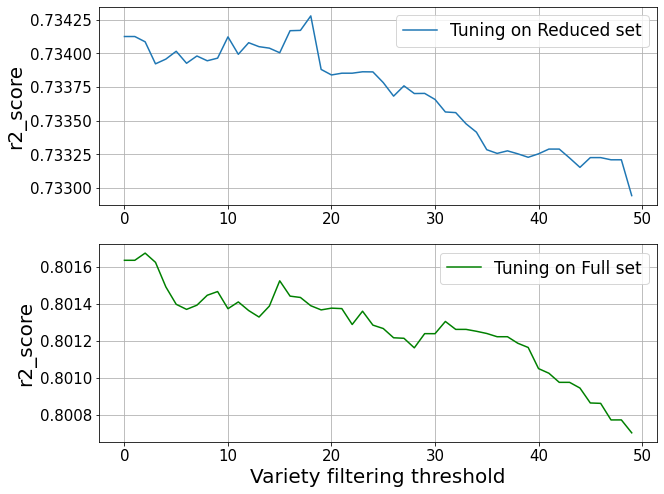

In [28]:
fig,ax= plt.subplots(nrows=2, figsize=(10,8))
ax[0].plot([el[1] for el in tuning_red], label= 'Tuning on Reduced set')
ax[1].plot([el[1] for el in tuning_full], 'g', label= 'Tuning on Full set')
ax[1].set_xlabel('Variety filtering threshold', fontsize=20)
ax[0].set_ylabel('r2_score', fontsize=20)
ax[1].set_ylabel('r2_score', fontsize=20)
ax[0].legend(fontsize=17)
ax[1].legend(fontsize=17)
ax[0].tick_params(labelsize=15)
ax[1].tick_params(labelsize=15)
ax[0].grid(True)
ax[1].grid(True)

In [29]:
fig.savefig('varietytuning.eps', format='eps', bbox_inches='tight')

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


In [105]:
# grid search on red_df

params = {
    "hidden_layer_sizes": [(10,), (10,100), (8,64,256),(32,64,128,256,256,256),(64,128,128,256,256,512,512,1024)],
    "activation": ['relu', 'tanh'],
    "learning_rate": ['constant', 'adaptive']
}

variety_filt_1h_red, variety_vocab_red = onehot_filtered(red_df, 'variety', 18) 

red_df_1h = sp.csr_matrix(pd.get_dummies(red_df.drop(columns=[
                                    'country', 'quality', 'description', 'designation', 'winery', 'region_2', 'variety']), columns=['province', 'region_1'], sparse=True))

winery_filt_1h_red, winery_vocab_red = onehot_filtered(red_df, 'winery', 2) 

vect_desig_red = TfidfVectorizer(stop_words='english', binary=True, use_idf=False, norm=False, min_df=2) 
tf_desig_red = vect_desig_red.fit_transform(red_df['designation'].fillna(''))

X_red = sp.hstack((variety_filt_1h_red, winery_filt_1h_red, tf_desig_red, red_df_1h), format='csr')
y_red = red_df['quality']

X_train_red, X_test_red, y_train_red, y_test_red = train_test_split(X_red, y_red, random_state=42, train_size=0.8)

scores_red = []
for config in ParameterGrid(params):
    print(f'Current: {config}...')
    rg = MLPRegressor(**config, early_stopping=True, max_iter=500, validation_fraction=0.05, random_state=42)
    rg.fit(X_train_red, y_train_red)
    score = r2_score(y_test_red, rg.predict(X_test_red))
    scores_red.append((config, score))
    print(f'Score: {score}')

Current: {'activation': 'relu', 'hidden_layer_sizes': (10,), 'learning_rate': 'constant'}...
Score: 0.7086027732161821
Current: {'activation': 'relu', 'hidden_layer_sizes': (10,), 'learning_rate': 'adaptive'}...
Score: 0.7086027732161821
Current: {'activation': 'relu', 'hidden_layer_sizes': (10, 100), 'learning_rate': 'constant'}...
Score: 0.7109240001811314
Current: {'activation': 'relu', 'hidden_layer_sizes': (10, 100), 'learning_rate': 'adaptive'}...
Score: 0.7109240001811314
Current: {'activation': 'relu', 'hidden_layer_sizes': (8, 64, 256), 'learning_rate': 'constant'}...
Score: 0.7214775159194098
Current: {'activation': 'relu', 'hidden_layer_sizes': (8, 64, 256), 'learning_rate': 'adaptive'}...
Score: 0.7214775159194098
Current: {'activation': 'relu', 'hidden_layer_sizes': (32, 64, 128, 256, 256, 256), 'learning_rate': 'constant'}...
Score: 0.7442096361296338
Current: {'activation': 'relu', 'hidden_layer_sizes': (32, 64, 128, 256, 256, 256), 'learning_rate': 'adaptive'}...
Score:

In [106]:
# grid search on dev_df 

variety_filt_1h_all, variety_vocab_all = onehot_filtered(dev_df, 'variety', 2) 

dev_df_1h = sp.csr_matrix(pd.get_dummies(dev_df.drop(columns=[
                                    'country', 'quality', 'description', 'designation', 'winery', 'region_2', 'variety']), columns=['province', 'region_1'], sparse=True))

winery_filt_1h_all, winery_vocab_all = onehot_filtered(dev_df, 'winery', 2) 

vect_desig_all = TfidfVectorizer(stop_words='english', binary=True, use_idf=False, norm=False, min_df=2) 
tf_desig_all = vect_desig_all.fit_transform(dev_df['designation'].fillna(''))

X_all = sp.hstack((variety_filt_1h_all, winery_filt_1h_all, tf_desig_all, dev_df_1h), format='csr')
y_all = dev_df['quality']

X_train, X_test, y_train, y_test = train_test_split(X_all, y_all, random_state=42, train_size=0.8)

scores_all = []
for config in ParameterGrid(params):
    print(f'Current: {config}...')
    rg = MLPRegressor(**config, early_stopping=True, max_iter=500, validation_fraction=0.05, random_state=42)
    rg.fit(X_train, y_train)
    score = r2_score(y_test, rg.predict(X_test))
    scores_all.append((config, score))
    print(f'Score: {score}')

Current: {'activation': 'relu', 'hidden_layer_sizes': (10,), 'learning_rate': 'constant'}...
Score: 0.789746580494369
Current: {'activation': 'relu', 'hidden_layer_sizes': (10,), 'learning_rate': 'adaptive'}...
Score: 0.789746580494369
Current: {'activation': 'relu', 'hidden_layer_sizes': (10, 100), 'learning_rate': 'constant'}...
Score: 0.7938202761861015
Current: {'activation': 'relu', 'hidden_layer_sizes': (10, 100), 'learning_rate': 'adaptive'}...
Score: 0.7938202761861015
Current: {'activation': 'relu', 'hidden_layer_sizes': (8, 64, 256), 'learning_rate': 'constant'}...
Score: 0.8070665726157545
Current: {'activation': 'relu', 'hidden_layer_sizes': (8, 64, 256), 'learning_rate': 'adaptive'}...
Score: 0.8070665726157545
Current: {'activation': 'relu', 'hidden_layer_sizes': (32, 64, 128, 256, 256, 256), 'learning_rate': 'constant'}...
Score: 0.8404377092188023
Current: {'activation': 'relu', 'hidden_layer_sizes': (32, 64, 128, 256, 256, 256), 'learning_rate': 'adaptive'}...
Score: 0

In [111]:
# train the best configuration with the full red_df

reg_final_red = MLPRegressor((64,128,128,256,256,512,512,1024), early_stopping=True, verbose=True, max_iter=500, validation_fraction=0.05, random_state=42, learning_rate='constant')
reg_final_red.fit(X_red, y_red)

Iteration 1, loss = 56.52716372
Validation score: 0.705925
Iteration 2, loss = 14.71908374
Validation score: 0.728531
Iteration 3, loss = 10.82578980
Validation score: 0.729310
Iteration 4, loss = 8.66709358
Validation score: 0.753053
Iteration 5, loss = 7.38915569
Validation score: 0.758459
Iteration 6, loss = 6.61352893
Validation score: 0.755300
Iteration 7, loss = 6.03779984
Validation score: 0.759424
Iteration 8, loss = 5.61065072
Validation score: 0.756350
Iteration 9, loss = 5.29254695
Validation score: 0.750102
Iteration 10, loss = 4.98547587
Validation score: 0.738694
Iteration 11, loss = 4.77140766
Validation score: 0.753341
Iteration 12, loss = 4.72634414
Validation score: 0.758632
Iteration 13, loss = 4.44340541
Validation score: 0.744393
Iteration 14, loss = 4.35205052
Validation score: 0.752851
Iteration 15, loss = 4.21015720
Validation score: 0.750319
Iteration 16, loss = 4.19727969
Validation score: 0.749078
Iteration 17, loss = 4.03539120
Validation score: 0.746119
Ite

MLPRegressor(early_stopping=True,
             hidden_layer_sizes=(64, 128, 128, 256, 256, 512, 512, 1024),
             max_iter=500, random_state=42, validation_fraction=0.05,
             verbose=True)

In [108]:
# train the best configuration with the full dev_df

reg_final_all = MLPRegressor((64,128,128,256,256,512,512,1024), early_stopping=True, verbose=True, max_iter=500, validation_fraction=0.05, random_state=42, learning_rate='constant')
reg_final_all.fit(X_all,y_all)

Iteration 1, loss = 44.24778787
Validation score: 0.785020
Iteration 2, loss = 11.04513348
Validation score: 0.811569
Iteration 3, loss = 7.81579716
Validation score: 0.852982
Iteration 4, loss = 6.15592799
Validation score: 0.851465
Iteration 5, loss = 5.45116236
Validation score: 0.849587
Iteration 6, loss = 4.84777445
Validation score: 0.860751
Iteration 7, loss = 4.56035509
Validation score: 0.862236
Iteration 8, loss = 4.25309702
Validation score: 0.869009
Iteration 9, loss = 3.95693855
Validation score: 0.866092
Iteration 10, loss = 3.88272924
Validation score: 0.857162
Iteration 11, loss = 3.64871652
Validation score: 0.869244
Iteration 12, loss = 3.42355885
Validation score: 0.869592
Iteration 13, loss = 3.30492802
Validation score: 0.872105
Iteration 14, loss = 3.28293155
Validation score: 0.871988
Iteration 15, loss = 3.33469143
Validation score: 0.864438
Iteration 16, loss = 3.10329766
Validation score: 0.867779
Iteration 17, loss = 3.09034942
Validation score: 0.865685
Iter

MLPRegressor(early_stopping=True,
             hidden_layer_sizes=(64, 128, 128, 256, 256, 512, 512, 1024),
             max_iter=500, random_state=42, validation_fraction=0.05,
             verbose=True)

# Unlabeled data preprocessing and prediction making

In [98]:
# defining methods to preprocess evaluation set

def get_dummies_existing(df_old, field, df_new):
    
    possibilities = sorted(list(filter(None, df_old[field].fillna('').unique())))
    exists = pd.Series(df_new[field])
    difference = pd.Series([item for item in possibilities if item not in exists])     
    exists = exists.where([name in possibilities for name in exists])
    target = exists.append(pd.Series(difference))
    target = target.reset_index(drop=True)
    dummies = pd.get_dummies(target)
    
    return sp.csr_matrix(dummies.drop(dummies.index[list(range(len(dummies)-len(difference), len(dummies)))]))


def get_dummies_existing_filtered(df_new, possibilities, field):
    
    exists = pd.Series(df_new[field])
    difference = pd.Series([item for item in possibilities if item not in exists])    
    exists = exists.where([name in possibilities for name in exists])
    target = exists.append(pd.Series(difference))
    target = target.reset_index(drop=True)
    dummies = pd.get_dummies(target)
    
    return sp.csr_matrix(dummies.drop(dummies.index[list(range(len(dummies)-len(difference), len(dummies)))]))

In [116]:
eval_df = pd.read_csv('eval.tsv', delimiter='\t', header=0)

In [99]:
# One-hot encoding of fields 'province' and 'region_1'; shape comparison

df_1h_eval_all = sp.hstack((get_dummies_existing(dev_df, 'province', eval_df), get_dummies_existing(dev_df, 'region_1', eval_df)), format='csr')
df_1h_eval_all, dev_df_1h

(<30186x1650 sparse matrix of type '<class 'numpy.uint8'>'
 	with 55268 stored elements in Compressed Sparse Row format>,
 <120744x1650 sparse matrix of type '<class 'numpy.uint8'>'
 	with 221475 stored elements in Compressed Sparse Row format>)

In [100]:
# filtered One-hot encoding of 'variety'; shape comparison

variety_filt_1h_eval = get_dummies_existing_filtered(eval_df, variety_vocab_all, 'variety')
variety_filt_1h_eval, variety_filt_1h_all

(<30186x500 sparse matrix of type '<class 'numpy.uint8'>'
 	with 30112 stored elements in Compressed Sparse Row format>,
 <120744x500 sparse matrix of type '<class 'numpy.uint8'>'
 	with 120641 stored elements in Compressed Sparse Row format>)

In [101]:
# filtered One-hot encoding of 'winery'; shape comparison

winery_filt_1h_eval = get_dummies_existing_filtered(eval_df, winery_vocab_all, 'winery')
winery_filt_1h_eval, winery_filt_1h_all

(<30186x10856 sparse matrix of type '<class 'numpy.uint8'>'
 	with 28249 stored elements in Compressed Sparse Row format>,
 <120744x10856 sparse matrix of type '<class 'numpy.uint8'>'
 	with 117495 stored elements in Compressed Sparse Row format>)

In [102]:
# filtered Beg-of-Word encoding of 'designation'; shape comparison

vect_desig_eval = TfidfVectorizer(stop_words='english', vocabulary=vect_desig_all.get_feature_names(), binary=True, use_idf=False, norm=False)
tf_desig_eval = vect_desig_eval.fit_transform(eval_df['designation'].fillna(''))

tf_desig_eval, tf_desig_all

(<30186x12433 sparse matrix of type '<class 'numpy.float64'>'
 	with 41736 stored elements in Compressed Sparse Row format>,
 <120744x12433 sparse matrix of type '<class 'numpy.float64'>'
 	with 175367 stored elements in Compressed Sparse Row format>)

In [103]:
# composition of the input matrix for the model

X_eval = sp.hstack((variety_filt_1h_eval, winery_filt_1h_eval, tf_desig_eval, df_1h_eval_all), format='csr')

In [109]:
# prediction (model trained with full development set)

y_pred_eval_all = reg_final_all.predict(X_eval)
eval_out_all = np.vstack((range(len(y_pred_eval_all)), y_pred_eval_all)).T

In [112]:
np.savetxt('sample_submission_all.csv', eval_out_all, fmt=('%.1d', '%.4f'), header='Id,Predicted', comments='', delimiter=',')

In [113]:
# preprocessing, composition of the input matrix and prediction (model trained with reduced development set)

df_1h_eval_red = sp.hstack((get_dummies_existing(red_df, 'province', eval_df), get_dummies_existing(red_df, 'region_1', eval_df)), format='csr')

variety_filt_1h_eval_red = get_dummies_existing_filtered(eval_df, variety_vocab_red, 'variety')

winery_filt_1h_eval_red = get_dummies_existing_filtered(eval_df, winery_vocab_red, 'winery')

vect_desig_eval_red = TfidfVectorizer(stop_words='english', vocabulary=vect_desig_red.get_feature_names(), binary=True, use_idf=False, norm=False)
tf_desig_eval_red = vect_desig_eval_red.fit_transform(eval_df['designation'].fillna(''))

X_eval_red = sp.hstack((variety_filt_1h_eval_red, winery_filt_1h_eval_red, tf_desig_eval_red, df_1h_eval_red), format='csr')
y_pred_eval_red = reg_final_red.predict(X_eval_red)

eval_out_red = np.vstack((range(len(y_pred_eval_red)), y_pred_eval_red)).T

In [115]:
np.savetxt('sample_submission_red.csv', eval_out_red, fmt=('%.1d', '%.4f'), header='Id,Predicted', comments='', delimiter=',')

In [118]:
# random guessing

eval_out_rnd = np.vstack((range(len(y_pred_eval_all)), np.random.normal(loc=50, scale=10, size = (len(y_pred_eval_all),)))).T
np.savetxt('sample_submission_rnd.csv', eval_out_rnd, fmt=('%.1d', '%.4f'), header='Id,Predicted', comments='', delimiter=',')